In [1]:
import os
import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [2]:

def parse_xml_annotation(file):
    tree = ET.parse(file)
    root = tree.getroot()

    file_name = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    boxes = []
    for obj in root.iter('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append({
            'label': label,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return file_name, width, height, boxes


data_dir = r"C:\Users\nguye\OneDrive\Desktop\UH\Spring 2023\CV\Project\archive\medical"
subfolders = [f.path for f in os.scandir(data_dir) if f.is_dir()]

annotations = []
for folder in subfolders:
    xml_files = glob.glob(os.path.join(folder, "*.xml"))

    for xml_file in xml_files:
        img_file, width, height, boxes = parse_xml_annotation(xml_file)
        img_path = os.path.join(folder, img_file)

        annotations.append({
            'img_path': img_path,
            'width': width,
            'height': height,
            'boxes': boxes
        })


def preprocess_image(image_path, target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image


# Split the dataset
annotations_train, annotations_test = train_test_split(annotations, test_size=0.2, random_state=42)
annotations_train, annotations_val = train_test_split(annotations_train, test_size=0.25, random_state=42)

# Set target image size
target_size = (416, 416)

# Preprocess images
train_images = [preprocess_image(a['img_path'], target_size) for a in annotations_train]
val_images = [preprocess_image(a['img_path'], target_size) for a in annotations_val]
test_images = [preprocess_image(a['img_path'], target_size) for a in annotations_test]

# Convert to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)


def annotations_to_coco(annotations, output_file):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    categories = set([box['label'] for a in annotations for box in a['boxes']])
    for i, category in enumerate(categories):
                coco_data["categories"].append({
            "id": i,
            "name": category
        })

    annotation_id = 1
    for image_id, a in enumerate(annotations):
        coco_data["images"].append({
            "id": image_id,
            "file_name": a['img_path'],
            "width": a['width'],
            "height": a['height']
        })

        for box in a['boxes']:
            category_id = next(c["id"] for c in coco_data["categories"] if c["name"] == box['label'])

            coco_data["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [
                    box['xmin'],
                    box['ymin'],
                    box['xmax'] - box['xmin'],
                    box['ymax'] - box['ymin']
                ],
                "iscrowd": 0,
            })
            annotation_id += 1

    with open(output_file, 'w') as f:
        json.dump(coco_data, f)

annotations_to_coco(annotations_train, "train_coco.json")
annotations_to_coco(annotations_val, "val_coco.json")



In [7]:
def get_num_classes_from_coco_json(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)
    return len(coco_data["categories"])

train_coco_path = "train_coco.json"
val_coco_path = "val_coco.json"


dataset_names = ["train_dataset", "val_dataset"]

for name in dataset_names:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)

register_coco_instances("train_dataset", {}, train_coco_path, data_dir)
register_coco_instances("val_dataset", {}, val_coco_path, data_dir)

train_metadata = MetadataCatalog.get("train_dataset")
val_metadata = MetadataCatalog.get("val_dataset")
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("val_dataset",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

num_classes = get_num_classes_from_coco_json(train_coco_path)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
cfg.TEST.EVAL_PERIOD = 1000

In [9]:
cfg.MODEL.DEVICE = "cpu"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "val_dataset")
inference_on_dataset(predictor.model, val_loader, evaluator)

[04/10 19:37:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (50, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (50,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (196, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (196,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[04/10 19:37:58 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\nguye\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/10 19:43:18 d2.utils.events]:  eta: 13:37:07  iter: 19  total_loss: 4.154  loss_cls: 3.852  loss_box_reg: 0.1702  loss_rpn_cls: 0.0975  loss_rpn_loc: 0.01838    time: 15.8494  last_time: 17.4416  data_time: 0.2594  last_data_time: 0.0026   lr: 4.9953e-06  
[04/10 19:49:00 d2.utils.events]:  eta: 13:31:38  iter: 39  total_loss: 3.967  loss_cls: 3.637  loss_box_reg: 0.1808  loss_rpn_cls: 0.07733  loss_rpn_loc: 0.01633    time: 16.3235  last_time: 16.6631  data_time: 0.0026  last_data_time: 0.0027   lr: 9.9902e-06  
[04/10 19:54:17 d2.utils.events]:  eta: 13:18:52  iter: 59  total_loss: 3.643  loss_cls: 3.197  loss_box_reg: 0.2985  loss_rpn_cls: 0.05165  loss_rpn_loc: 0.01484    time: 16.1633  last_time: 15.4591  data_time: 0.0024  last_data_time: 0.0028   lr: 1.4985e-05  
[04/10 19:59:27 d2.utils.events]:  eta: 13:03:34  iter: 79  total_loss: 2.931  loss_cls: 2.45  loss_box_reg: 0.2406  loss_rpn_cls: 0.07121  loss_rpn_loc: 0.01844    time: 15.9948  last_time: 14.4021  data_time: 0.00

AssertionError: A prediction has class=47, but the dataset only has 47 classes and predicted class id should be in [0, 46].

[04/11 10:16:10 d2.data.datasets.coco]: Loaded 789 images in COCO format from val_coco.json


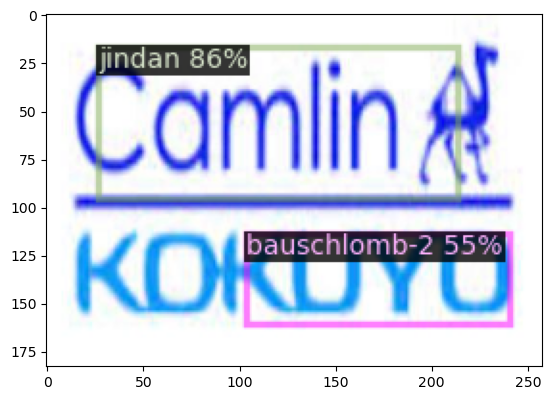

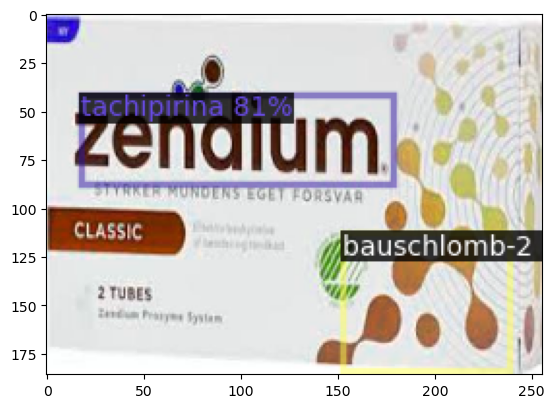

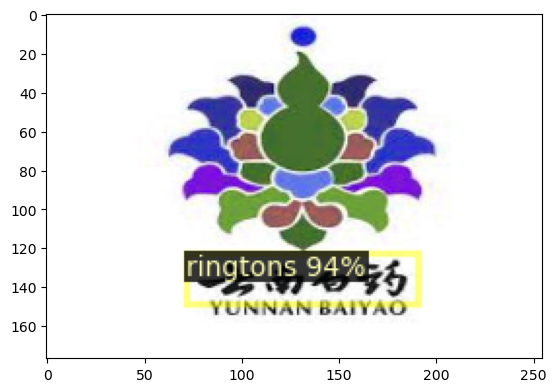

In [10]:
val_dicts = DatasetCatalog.get("val_dataset")
for d in random.sample(val_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_metadata, scale=0.5)
    outputs = predictor(img)
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()